<a href="https://colab.research.google.com/github/Archi-Ahsan/mL/blob/main/210151_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA


In [25]:
url = "https://raw.githubusercontent.com/Archi-Ahsan/mL/refs/heads/main/heart.csv"
data = pd.read_csv(url)

data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [26]:
# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

X = X.fillna(X.mean())

X = pd.get_dummies(X, drop_first=True)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [28]:
cart = DecisionTreeClassifier(criterion='gini', random_state=42)

param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}

cart_grid = GridSearchCV(cart, param_grid, cv=5, scoring='accuracy')
cart_grid.fit(X_train, y_train)

best_cart = cart_grid.best_estimator_

print("Best CART Parameters:", cart_grid.best_params_)


Best CART Parameters: {'max_depth': None, 'min_samples_split': 2}


In [29]:
id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

id3_grid = GridSearchCV(id3, param_grid, cv=5, scoring='accuracy')
id3_grid.fit(X_train, y_train)

best_id3 = id3_grid.best_estimator_

print("Best ID3 Parameters:", id3_grid.best_params_)


Best ID3 Parameters: {'max_depth': None, 'min_samples_split': 2}


In [30]:
cart_pred = best_cart.predict(X_test)
cart_prob = best_cart.predict_proba(X_test)[:,1]

id3_pred = best_id3.predict(X_test)
id3_prob = best_id3.predict_proba(X_test)[:,1]


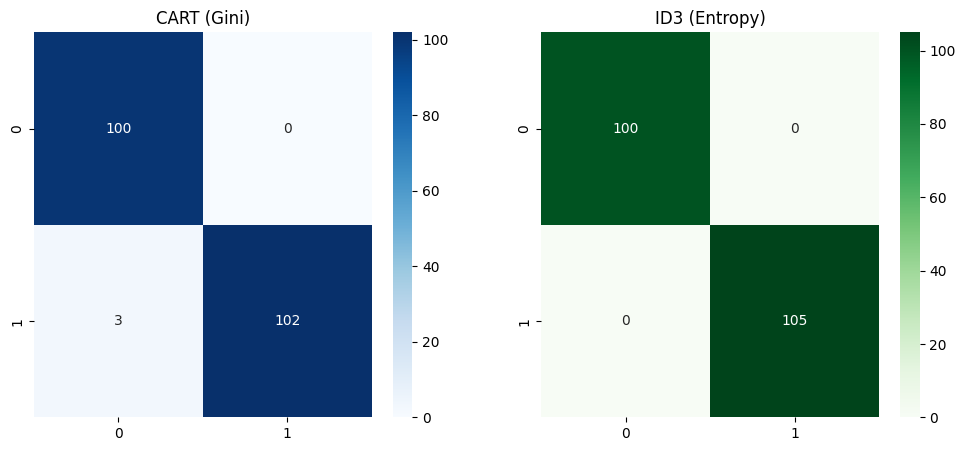

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, cart_pred),
            annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("CART (Gini)")

sns.heatmap(confusion_matrix(y_test, id3_pred),
            annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("ID3 (Entropy)")

plt.show()


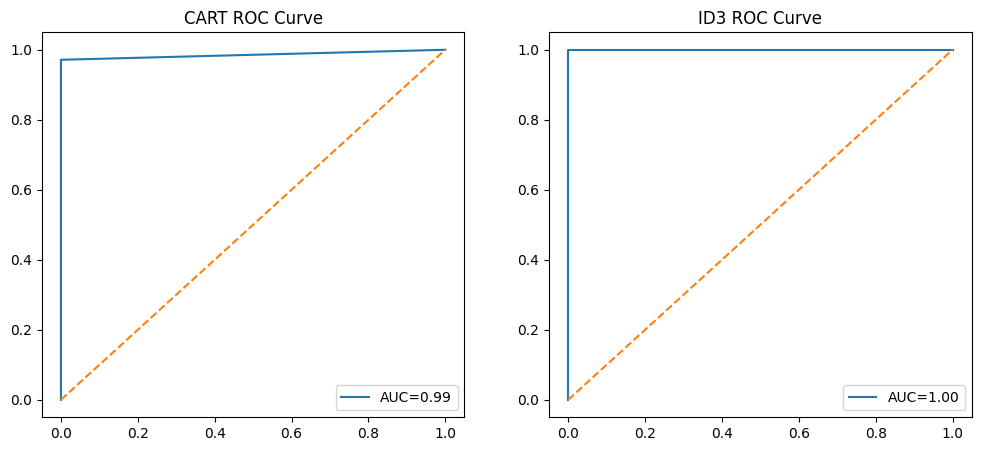

In [32]:
cart_fpr, cart_tpr, _ = roc_curve(y_test, cart_prob)
id3_fpr, id3_tpr, _ = roc_curve(y_test, id3_prob)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(cart_fpr, cart_tpr, label=f"AUC={roc_auc_score(y_test, cart_prob):.2f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_title("CART ROC Curve")
axes[0].legend()

axes[1].plot(id3_fpr, id3_tpr, label=f"AUC={roc_auc_score(y_test, id3_prob):.2f}")
axes[1].plot([0,1],[0,1],'--')
axes[1].set_title("ID3 ROC Curve")
axes[1].legend()

plt.show()


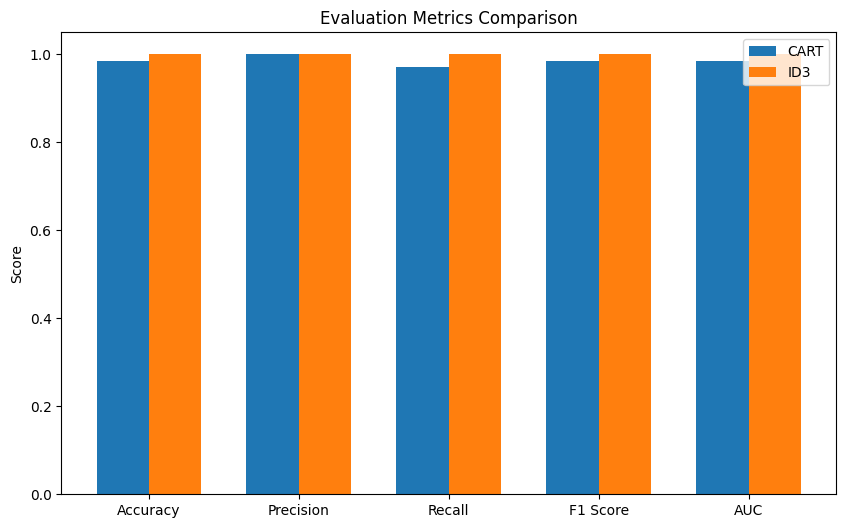

In [33]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

cart_scores = [
    accuracy_score(y_test, cart_pred),
    precision_score(y_test, cart_pred),
    recall_score(y_test, cart_pred),
    f1_score(y_test, cart_pred),
    roc_auc_score(y_test, cart_prob)
]

id3_scores = [
    accuracy_score(y_test, id3_pred),
    precision_score(y_test, id3_pred),
    recall_score(y_test, id3_pred),
    f1_score(y_test, id3_pred),
    roc_auc_score(y_test, id3_prob)
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, cart_scores, width, label='CART')
plt.bar(x + width/2, id3_scores, width, label='ID3')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Evaluation Metrics Comparison')
plt.legend()
plt.show()


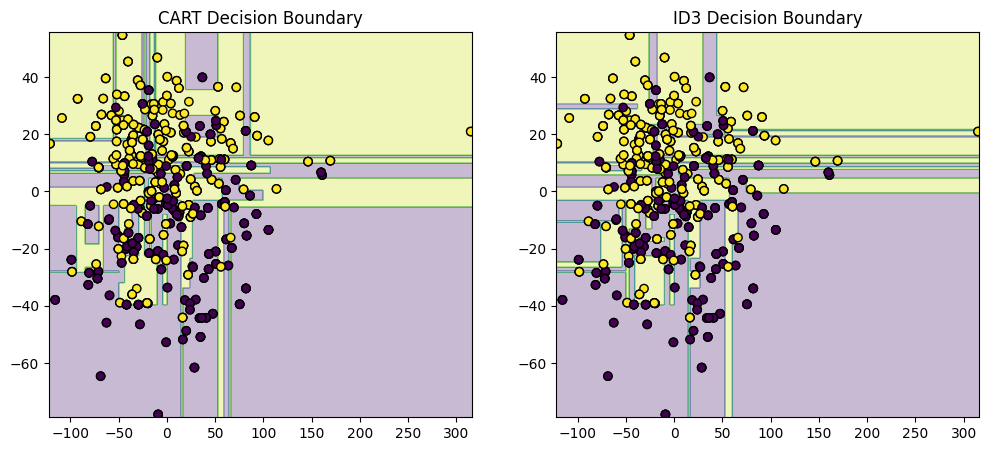

In [34]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

cart_2d = DecisionTreeClassifier(**cart_grid.best_params_, criterion='gini')
cart_2d.fit(X_pca, y_train)

id3_2d = DecisionTreeClassifier(**id3_grid.best_params_, criterion='entropy')
id3_2d.fit(X_pca, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 300),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 300)
)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

for model, ax, title in zip(
    [cart_2d, id3_2d],
    axes,
    ["CART Decision Boundary", "ID3 Decision Boundary"]
):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X_pca[:,0], X_pca[:,1], c=y_train, edgecolor='k')
    ax.set_title(title)

plt.show()


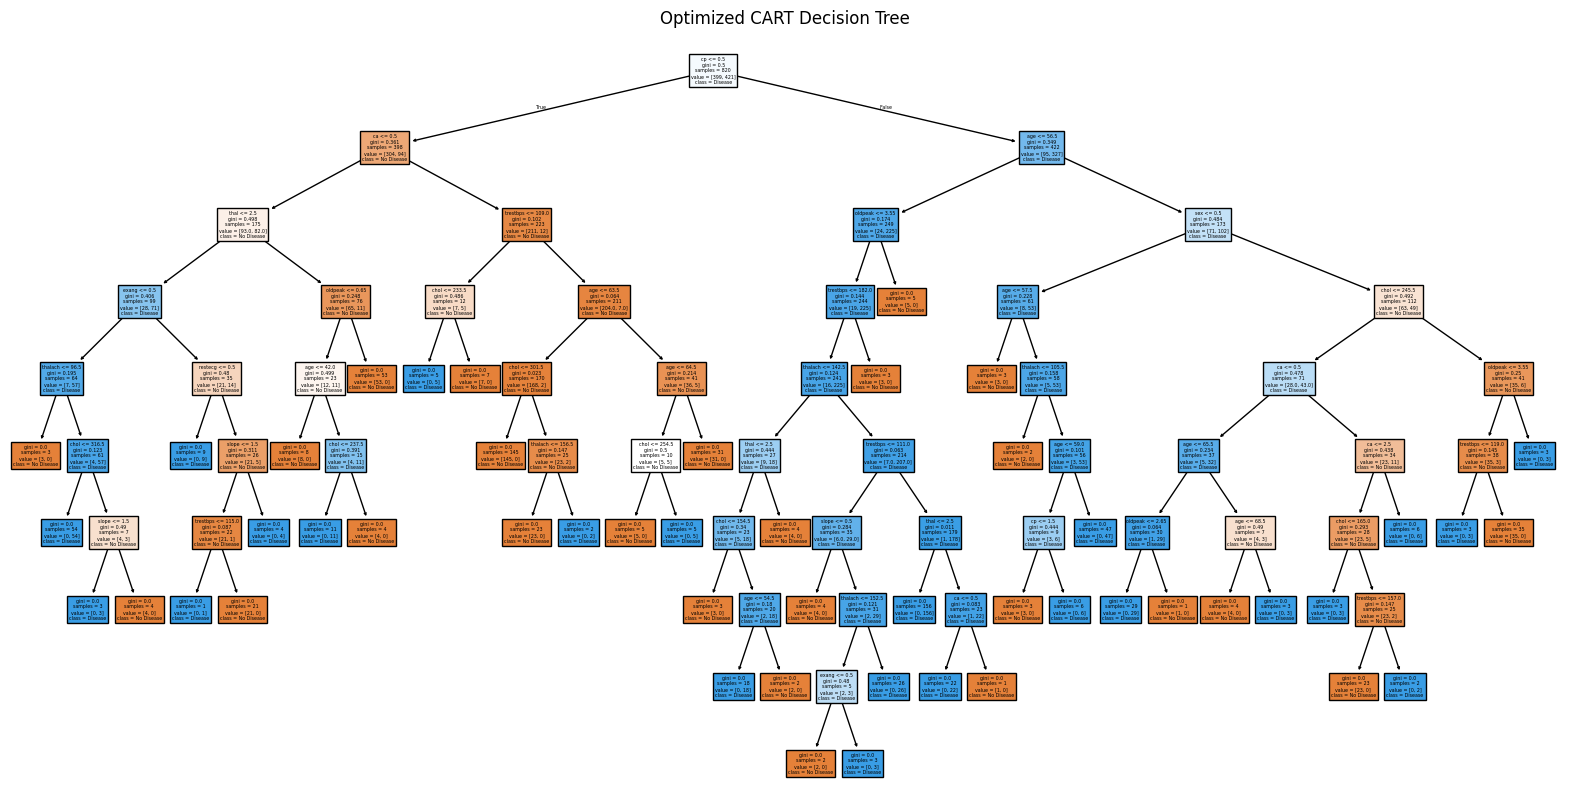

In [35]:
plt.figure(figsize=(20,10))
plot_tree(
    best_cart,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True
)
plt.title("Optimized CART Decision Tree")
plt.show()
